# Clustering-Analyse


[1. Clustering auf originalen Daten](#1.-clustering-auf-originalen-daten)


In [2]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

%store -r data_original_reduced_tsne
%store -r data_topics_reduced_tsne

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

data_original_reduced_tsne = data_original_reduced_tsne
data_topics_reduced_tsne = data_topics_reduced_tsne

In [3]:
# Set environment variable (only relevant for Windows-OS). Necessary for avoiding warnings of memory leaks while executing cluster-algorithms.
import os
os.environ["OMP_NUM_THREADS"] = '1'

# 1. Clustering auf originalen Daten

## 1.1 Vorbereitung des Datensets für Clustering-Algorithmen

### 1.1.1 Entfernen von nicht-numerischen Features

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score

In [5]:
# !pip install yellowbrick
# %pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

- Erstellen eines Datensets mit ausschließlich numerischen Features, um Rechenoperationen bei Cluster-Algorithmen zu ermöglichen
- Die ausgegebenen Features wurden hierfür entfernt...

In [6]:
# Create a copy of data (with only numerical values)
data_numerical = data.copy().select_dtypes(include='number')
set(data.columns) - set(data_numerical.columns)

{'Geschlecht',
 'Was ist dein Lieblingsessen? (nur eines angeben)',
 'Was ist deine Lieblingsband bzw. dein/e Lieblings-Musiker*in?\n(nur eine/n angeben)',
 'Was ist deine absolute Lieblingssportart?',
 'Welchem Studiengang fühlst du dich am meisten zugehörig?',
 'Welcher Funktion an der HSD fühlst du dich am meisten\nzugehörig?'}

Die folgenden Features sind nach der ersten Filterung noch enthalten...

In [7]:
data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 56 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype
---  ------                                                                                                                      --------------  -----
 0   Alter                                                                                                                       62 non-null     int64
 1   Als wie sportlich würdest du dich einschätzen?                                                                              62 non-null     int64
 2   Welche Rolle spielt für dich gesunde Ernährung?                                                                             62 non-null     int64
 3   Wie gerne gehst du Essen oder Trinken?                                                                                      62 non-null  

### 1.1.2 Skalieren der Daten

Da fast alle Fragen einen Zahlenraum von 1-5 vorgegeben hatten, müsste hierfür eigentlich keine Skalierung durchgeführt werden. Trotzdem skalieren wir die Daten, insb. aus den folgenden Gründen:

- Einzelne Features wie z. B. "Alter" machen eine Skalierung notwendig, da Clustering-Algorithmen sonst verschiedene Zahlenräume vergleichen würde
- Wenn in Zukunft weitere/andere Features (z. B. mit Zahlenraum von 1-10) eingeführt werden, sind die dargestellten Ansätze trotzdem langfristig nutzbar

In [8]:
# WIP: Filter out features that seem to be not relevant for clustering
cols_remove = [
            #     'AcceptedCmp3', 'AcceptedCmp4',
            #    'AcceptedCmp5', 'AcceptedCmp1',
            #    'AcceptedCmp2', 'Complain', 'Response'
               ]
data_numerical = data_numerical.drop(cols_remove, axis=1)

# Scaling
scaler = StandardScaler()
scaler.fit(data_numerical)
data_numerical_scaled = pd.DataFrame(scaler.transform(data_numerical),
                           columns= data_numerical.columns )

data_numerical_scaled.head()

,Alter,Als wie sportlich würdest du dich einschätzen?,Welche Rolle spielt für dich gesunde Ernährung?,Wie gerne gehst du Essen oder Trinken?,Wie gerne kochst du selbst?,Wie gerne gehst du feiern?,Wie sehr interessierst du dich für Musik?,Wie gerne liest Du?,"Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?","Wie sehr interessierst du sich für Filme, Kino, Fernsehsendungen?",...,Interesse an Leichtathletik? (encoded),Interesse an Reiten? (encoded),Interesse an Rennrad/Mountainbike? (encoded),Interesse an Schwimmen? (encoded),Interesse an Tanzen? (encoded),Interesse an Tennis? (encoded),Interesse an Volleyball? (encoded),Interesse an Wassersport? (encoded),Interesse an Wintersport? (encoded),Interesse an Yoga? (encoded)
0,0.555073,0.728893,0.552967,-0.871197,0.181800,0.153296,1.071517,0.727409,0.314127,-0.827253,...,-0.356753,-0.182574,1.941451,-0.74162,-0.564933,-0.3849,-0.614636,-0.262613,-0.296174,1.941451
1,0.105210,-0.298183,0.552967,0.147939,1.206488,-0.710737,0.000000,-0.912567,0.314127,0.287740,...,-0.356753,-0.182574,1.941451,-0.74162,-0.564933,-0.3849,1.626978,-0.262613,-0.296174,1.941451
2,-0.344653,-1.325259,1.777393,0.147939,0.181800,0.153296,1.071517,-0.912567,0.314127,0.287740,...,-0.356753,-0.182574,-0.515079,-0.74162,1.770122,-0.3849,-0.614636,-0.262613,-0.296174,1.941451
3,-0.569585,1.755968,-1.895886,0.147939,0.181800,-0.710737,-1.071517,-0.092579,-0.532650,0.287740,...,2.803060,-0.182574,-0.515079,-0.74162,-0.564933,-0.3849,-0.614636,-0.262613,3.376389,-0.515079
4,-0.344653,-0.298183,0.552967,-0.871197,-1.867577,-1.574770,-1.071517,0.727409,-0.532650,1.402733,...,-0.356753,-0.182574,-0.515079,-0.74162,-0.564933,-0.3849,-0.614636,-0.262613,-0.296174,-0.515079


- Hilfsfunktion, die zur Darstellung von mehreren Plots bei der Auswertung der Clustering-Algorithmen genutzt werden kann

In [9]:
# Input:
#   - results:  Computation results as an array of tuples with the form [("<<plot title>>", [<<dataframe>>])], where the dataframe has the x- & y-coordinates of the datapoints in the first and second column and the cluster-assigment in the third column
#   - figsize_columns: number of columns which are used to layout the plotted graphs. The number of rows is depending on the number of 'results' and the given 'figsize_columns'.
# Ouput: The plotted graphs which represent the given data from 'results'

def display_clustering(data, figsize_columns, figsize = (15, 15)):
    figsize_rows = math.ceil(len(data) / figsize_columns)
    fig, ax = plt.subplots(figsize_rows, figsize_columns, figsize=figsize)
    fig.tight_layout(pad=3)

    for i in range(len(data)):
        plt.subplot(figsize_rows, figsize_columns, i+1).set_title(data[i][0])

        current_dataframe = data[i][1]
        plt.subplot(figsize_rows, figsize_columns, i+1).scatter(
            current_dataframe[current_dataframe.columns[0]],
            current_dataframe[current_dataframe.columns[1]],
            c=current_dataframe[current_dataframe.columns[2]],
            cmap="viridis")

## 1.2 k-Means Clustering

k-Means ist ein abstandsbasierter, vergleichsweise einfacher Algorithmus. Die Anzahl der zu bildenden Cluster muss hierbei jedoch explizit angegeben werden, weshalb im folgenden versucht wird, ein sinnhafte Anzahl von Clustern zu bestimmen.

### 1.2.1 Finden von Parametern mit "Elbow-Method"

- Die Anzahl der Cluster muss bei k-Means explizit gewählt werden
- Für die Wahl der Clusteranzahl gibt es keine feste Metrik, sondern nur Heuristiken zur Annäherung an einen geeigneten Wert
- Nutzen von "Elbow-Method" zum finden einer geeigneten Clusteranzahl: Durch das automatische Berechnen der Cluster mit k-Means für verschiedene Clustergrößen und die Berechnung des "Distortion"-Wertes kann ein Anhaltspunkt für eine geeignete Clustergröße gefunden werden
- Im Optimalfall hat die Funktion einen "Knick", ab dem eine größere Clusteranzahl die Summe der Abstände der Datenpunkte im Cluster zum Clusterzetrum (Distortion) nicht signifikant verbessert

- scitkit stellt einen eigenen Visualizer zum Berechnen/Darstellen der Methode bereit
    - Übergabe des zu nutzenden Models (hier KMeans)
    - Übergabe der zu testenden Clustergrößen (hier 2-10, 2-20 & 2-30, um allg. Überblick zu bekommen)

Analyse für die Clustergrößen 2-10

c:\Users\Konstantin\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\Konstantin\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


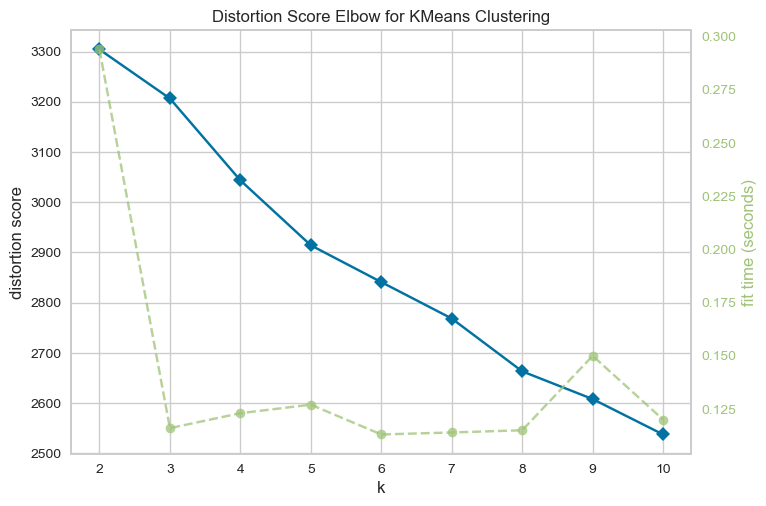

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=10)

visualizer.fit(data_numerical_scaled)
visualizer.show()

Analyse für die Clustergrößen 2-20

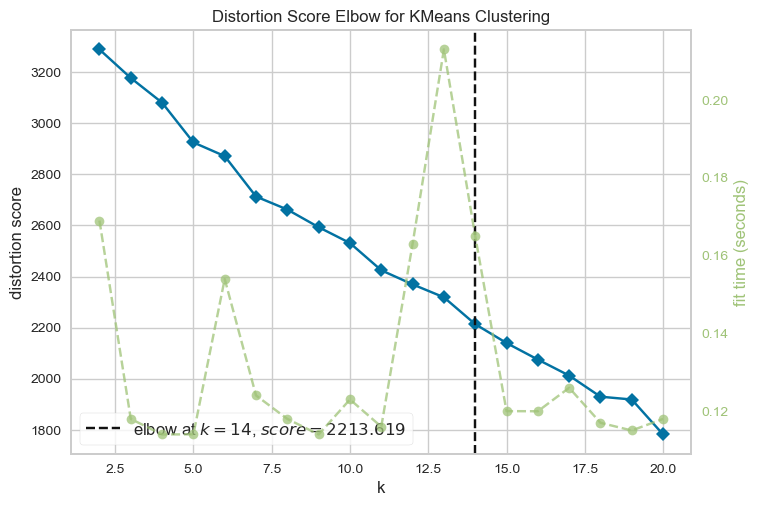

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=20)

visualizer.fit(data_numerical_scaled)
visualizer.show()

Analyse für die Clustergrößen 2-30

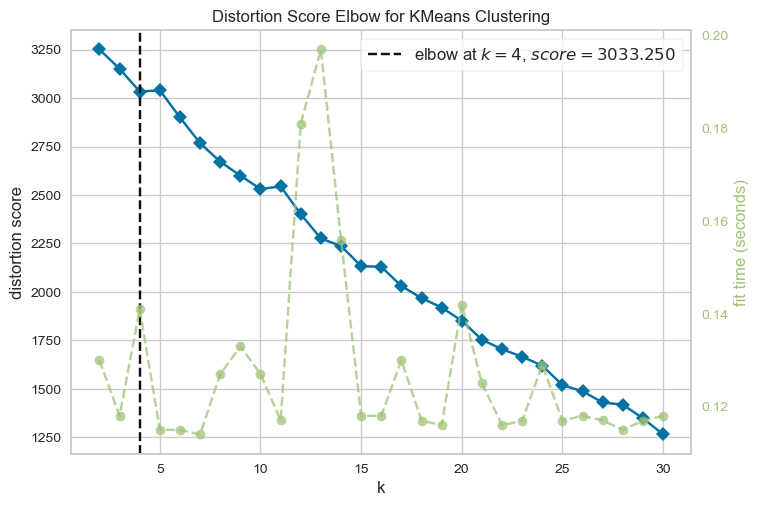

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=30)

visualizer.fit(data_numerical_scaled)
visualizer.show()

### Erkenntnisse / Beobachtungen

- Der "distortion score" (d. h. der Durchschnitt der quadrierten Abstände von jedem Punkt zu seinem zugewiesenen Clusterzentrum) nimmt bzgl. der Clusteranzahl k tendenziell linear ab, wodurch kein eindeutiger "Elbow" zu erkennen ist  
    -> Es scheint keine eindeutige Clusteranzahl zu geben, bei der die Daten eindeutig zuordbar sind
- Von der Größenordnung scheint anhand der "Elbow"-Methode eine Clustergröße von mindestens 5 sinnvoll zu sein; Eindeutig ist das Ergebnis jedoch nicht

### 1.2.2 Manuelle Suche von Cluster-Parametern

- Da die "Elbow"-Methode nicht eindeutig war: Testen verschiedener Parameterwerte für k-Means Algorithmus
- Verschachtelte for-Schleife an sich ineffizient für Berechnung, aber aufgrund der vergleichsweise geringen Laufzeit & Komplexität von k-Means noch vertretbar

In [38]:
def compute_kmeans(data, cluster_params_n_clusters):
    kmeans_iterations = []
    kmeans_scores = pd.DataFrame(columns=["n_samples", "score"])

    for param_cluster in cluster_params_n_clusters:
        parameter_string = "n_samples: " + str(param_cluster)
        kmeans = KMeans(n_clusters=param_cluster, random_state=0, n_init='auto').fit(data)

        data_original_reduced_tsne_kmeans = data_original_reduced_tsne.copy()
        data_original_reduced_tsne_kmeans["cluster"] = kmeans.labels_
        kmeans_iterations.append((parameter_string, data_original_reduced_tsne_kmeans))

        score = silhouette_score(data_original_reduced_tsne, kmeans.labels_)
        kmeans_scores.loc[len(kmeans_scores)] = {'n_samples':param_cluster, 'score':score}
    
    return kmeans_iterations, kmeans_scores

In [39]:
cluster_params_n_clusters = [3, 5, 10, 15, 20, 25, 30, 40, 50]
kmeans_iterations, kmeans_scores = compute_kmeans(data_numerical_scaled, cluster_params_n_clusters)

- Die gefundenen Cluster werden für eine erste Übersicht mit den auf 2D-reduzierten Featuren (mithilfe von t-SNE) visualisiert

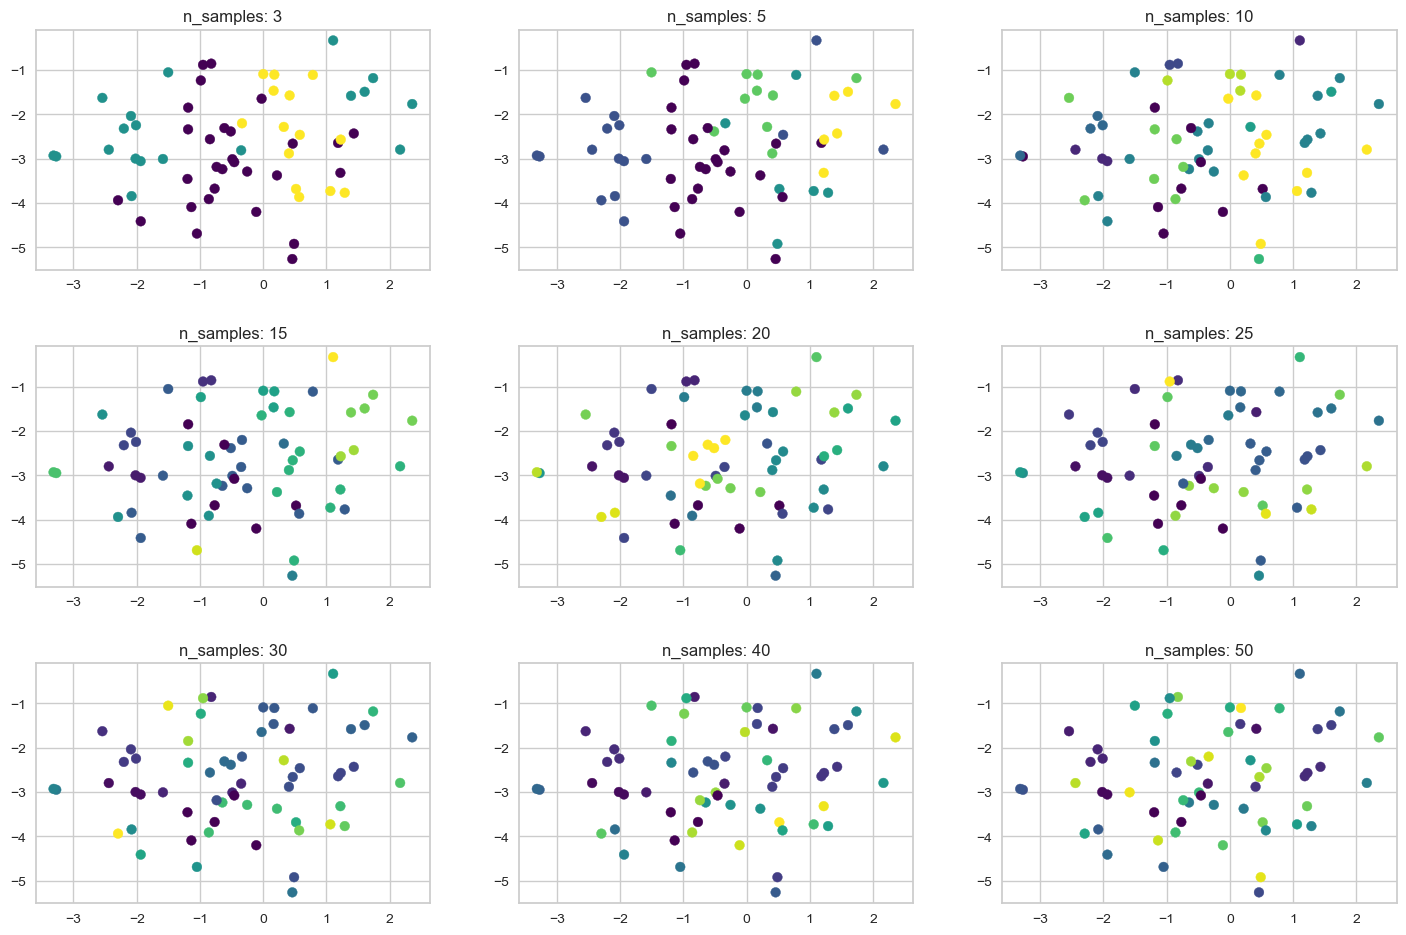

In [14]:
display_clustering(kmeans_iterations, 3, (15, 10))

- Als messbare Metrik zur Auswertung des Clusterings eurde im Rahmen der "Silhouette Analysis" der "Silhouette Coefficient" berechnet. Dieser ist je Cluster laut der [Dokumentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) wie folgt zu interpretieren:
    - Wert < 0: Datenpunkt wurde ggf. einem falschen Cluster zugeordnet
    - Wert nahe 0: Datenpunkt befindet sich an Rand eines Clusters und wurde bei Abstandsmessung ggf. dem falschen Cluster zugeordnet
    - Wert > 0: Der Datenpunkt ist vergleichsweise weit vom nächsten Cluster entfernt (und somit vergleichsweise eindeutig zugeordnet)

In [15]:
kmeans_scores

,n_samples,score
0,3,0.035178
1,5,0.079642
2,10,-0.169217
3,15,-0.083480
4,20,-0.063154
5,25,-0.092400
6,30,-0.098777
7,40,-0.023485
8,50,0.049037


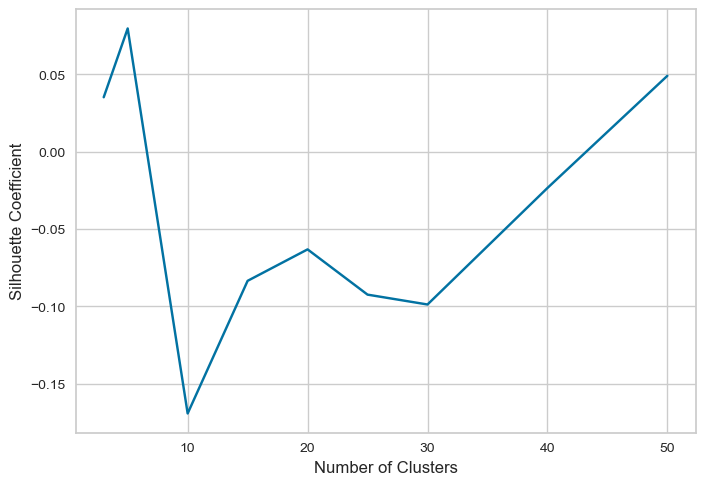

In [16]:
plt.plot(kmeans_scores.n_samples, kmeans_scores.score)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Visualierungen des Clusterings für den "n_samples"-Wert 5 mit einzelnen Feature-Kombinationen, um Strukturen in den Clustern zu untersuchen

In [17]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto').fit(data_numerical_scaled)
data_numerical["Cluster"] = kmeans.labels_

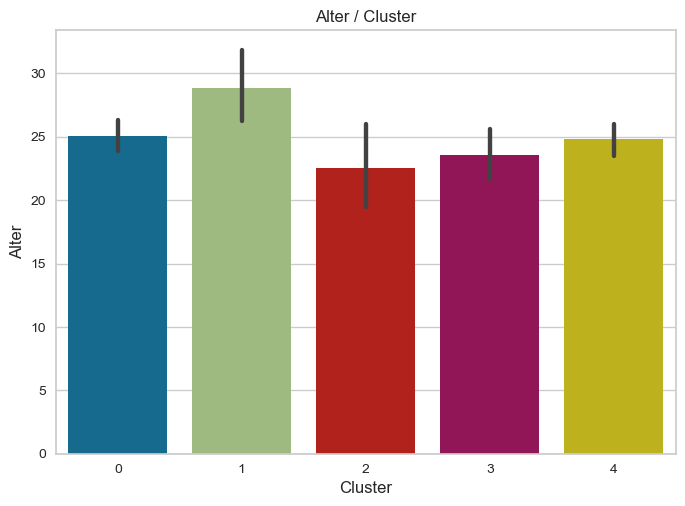

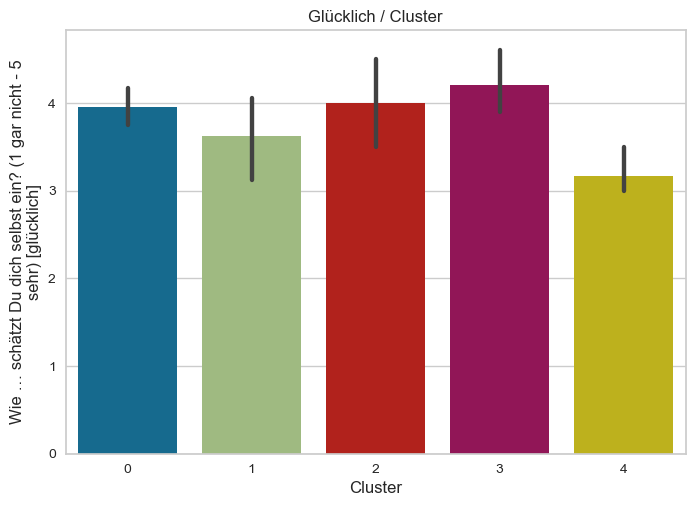

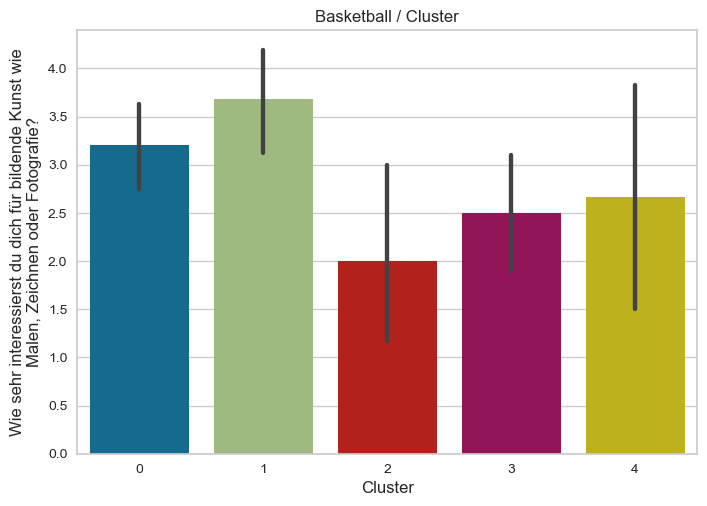

In [18]:
sb.barplot(x='Cluster', y=columns.alter, data=data_numerical)
plt.title("Alter / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.gluecklich, data=data_numerical)
plt.title("Glücklich / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.malen, data=data_numerical)
plt.title("Basketball / Cluster")
plt.show()

### Ergebnisse / Beobachtungen
- Sowohl die Plots, als auch die Scores der "Silhouette Analysis" lassen feststellen, dass die Einteilung der Daten zu Clustern nur eingeschränkt funktioniert hat
    - Für die "n_samples" 5 & 10 sind jedoch immerhin grobe Clusterstrukturen erkennbar
- Offensichtlich steigt der Score der "Silhouette Analysis" bei einer Clusterzahl über 30 stärker an, da ab diesem Wert zunehmend Datenpunkte als einzelne Cluster eingeteilt werden und somit vergleichsweise "gut" eingeordnet werden. Praktisch ist eine solche hohe Zahl an Clustern bei der geringen Anzahl von Datenpunkten aber nicht zielführend
- In der Untersuchung des Clusterings für einzelne Features scheinen die Cluster keine bestimmten Eigenschaften der Datenpunkte zu trennen, was gegen ein erfolgreiches Clustering spricht

## 1.3 DBSCAN

### 1.3.1 Finden von Parametern mit "Elbow-Method"

- Zu setzende Parameter: minPts (Maß für Erreichbarkeit eines Punktes) & epsilon (Nachbarschaftslänge)

minPts
- Empfehlung nach [Sander et al., 1998](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (für mehrdimensionale Daten): 2*Anzahl der Dimensionen
- Problem: Daten haben sehr viele Features, aber vergleichsweise wenig Datenpunkte
- Bei Beachtung der Heuristik würde die Clusteranzahl die Anzahl der Datenpunkte übersteigen
- Mögliche Lösung: Anwenden von DBSCAN auf reduzierten Daten (siehe untere Kapitel)

epsilon
- Schema nach [Rahmah and Sitanggang, 2016](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf): Die durchschnittliche Distanz von jedem Datenpunkt zu seinen "n_neighbors" (minPts-Wert) berechnen
- Ähnlich zur "Elbow-Method" kann dann am Graphen der Punkt abgelesen werden, ab dem ein kleinerer Wert keinen nennenswerten positiven Einfluss auf die Clusterbildung hat

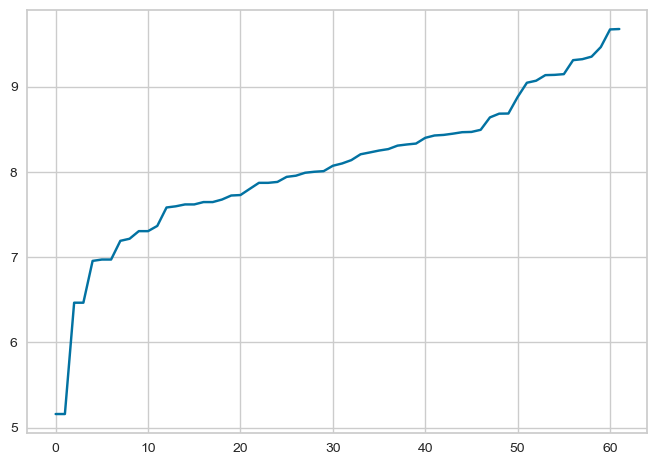

In [19]:
# based on https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(data_numerical_scaled)
distances, indices = neighbors_fit.kneighbors(data_numerical_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### 1.3.2 Festlegen von Cluster-Parametern mit manueller Parametersuche

In [52]:
def compute_dbscan(data, cluster_params_min_samples, cluster_params_eps):
    dbscan_iterations = []

    for min_samples in cluster_params_min_samples:
        for eps in cluster_params_eps:
            parameter_string = "eps: " + str(eps) + ", minPts: " + str(min_samples)

            dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
            data_original_reduced_tsne_dbscan = data_original_reduced_tsne.copy()
            data_original_reduced_tsne_dbscan["cluster"] = dbscan.labels_
            dbscan_iterations.append((parameter_string, data_original_reduced_tsne_dbscan))
    
    return dbscan_iterations

In [53]:
cluster_params_min_samples = [1, 2, 5, 10, 15, 20, 30, 40]
cluster_params_eps = [5, 5.5, 6, 6.7, 7, 7.3, 8, 9]

dbscan_iterations = compute_dbscan(data_numerical_scaled, cluster_params_min_samples, cluster_params_eps)

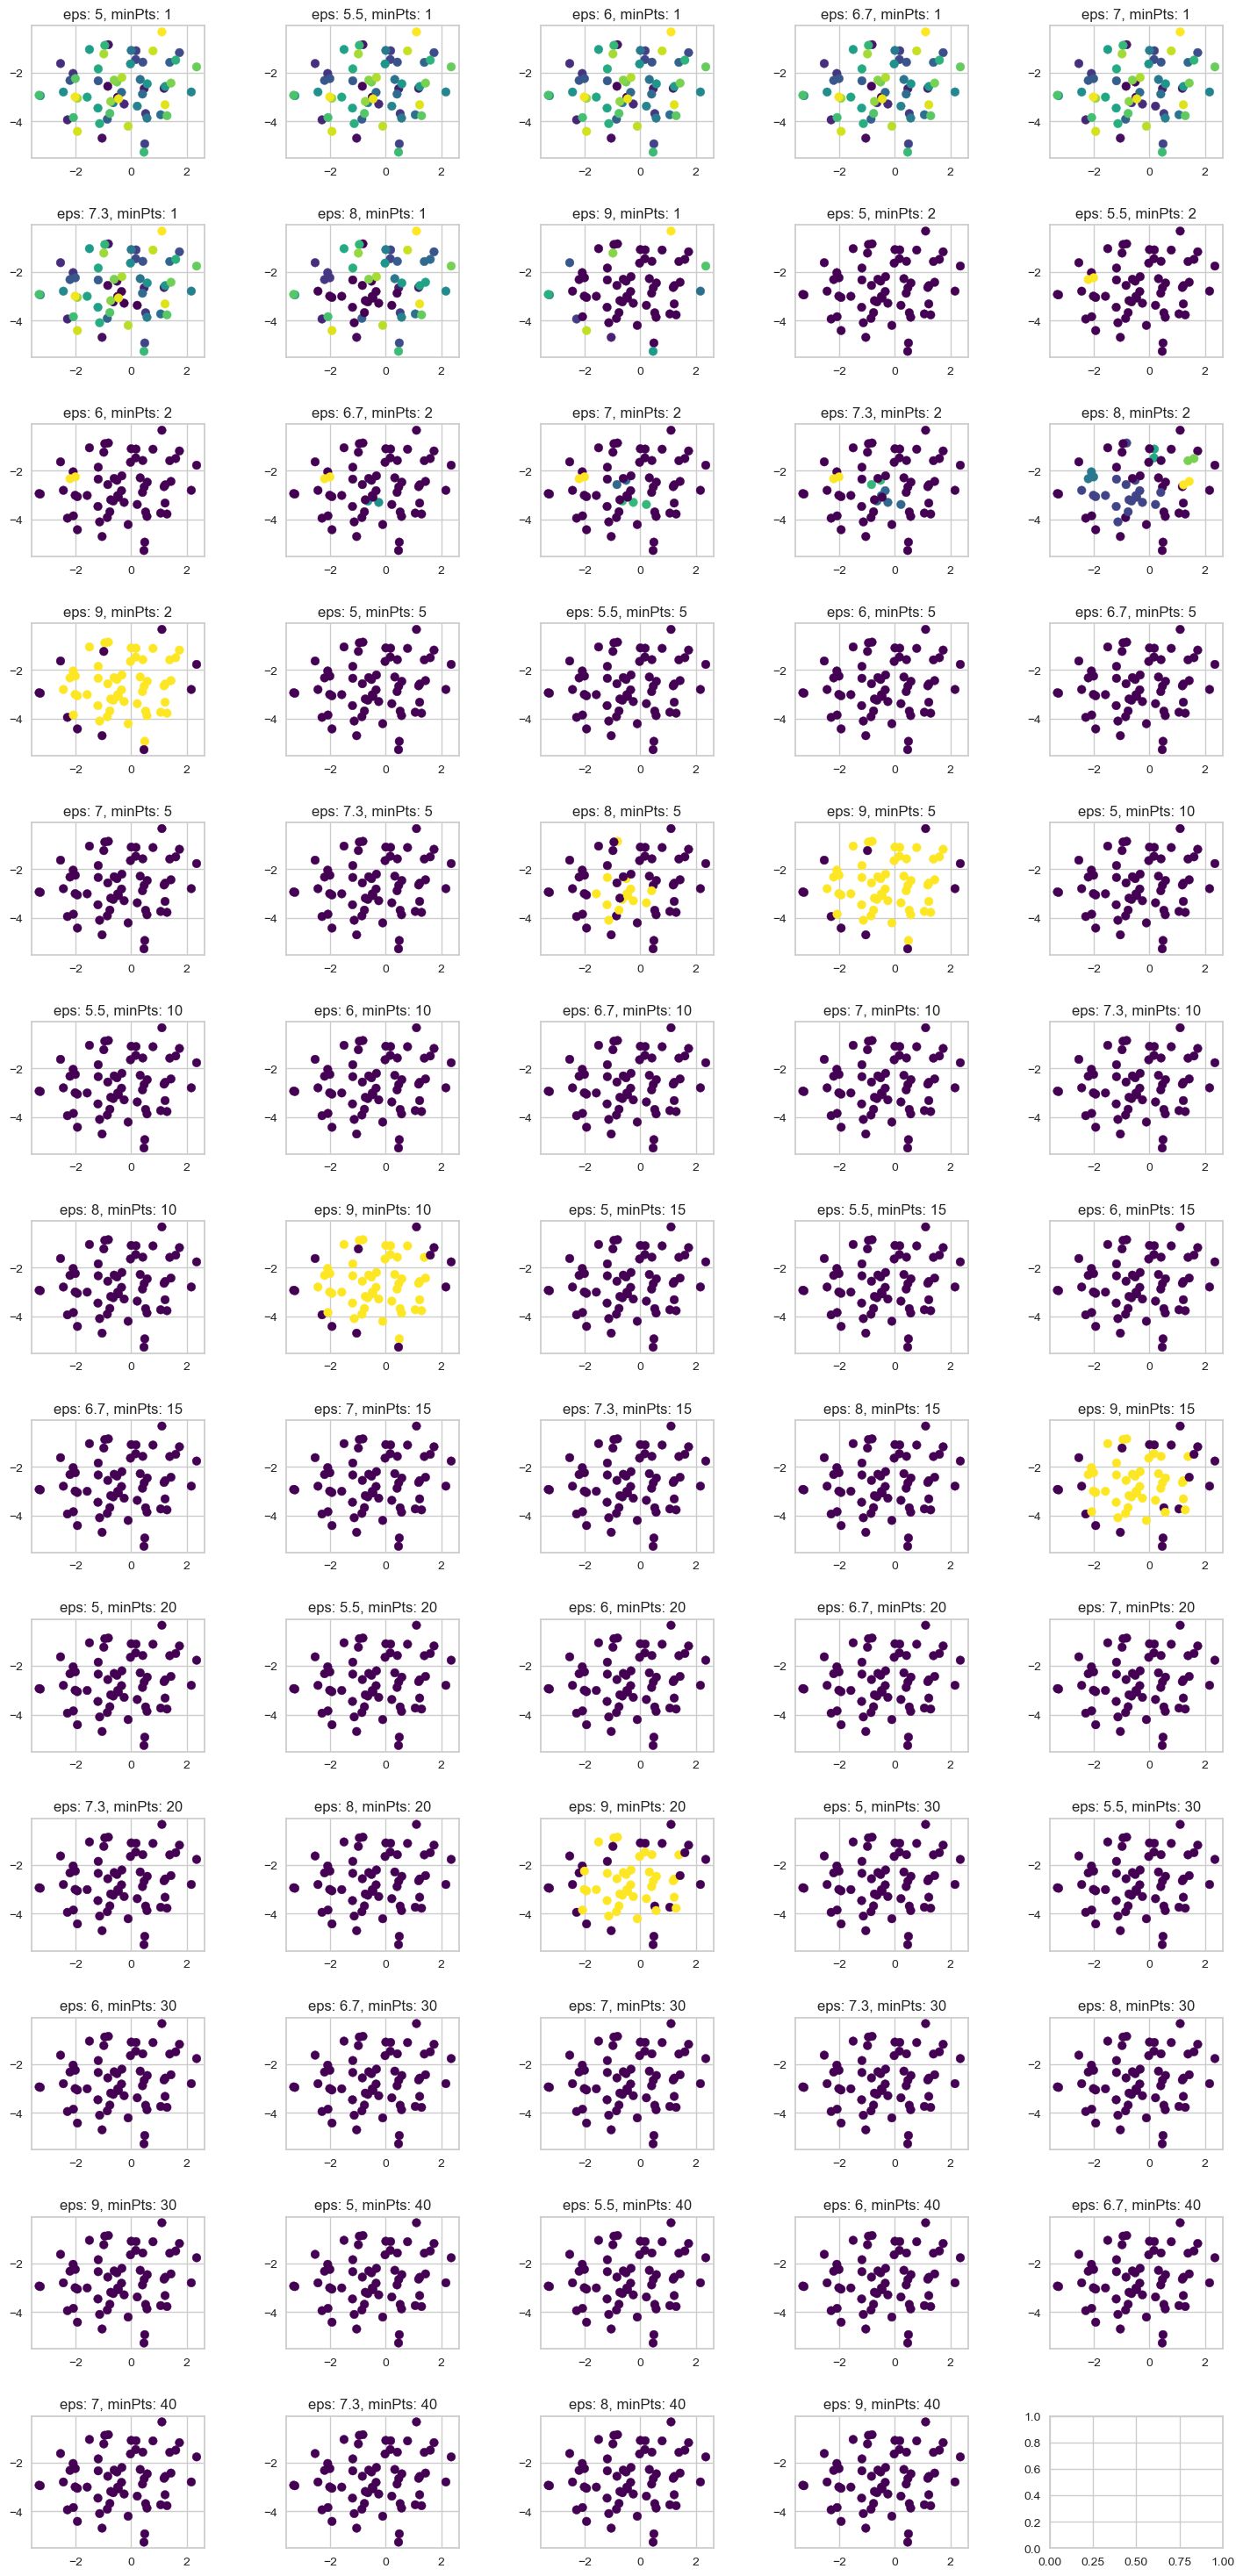

In [21]:
display_clustering(dbscan_iterations, 5, (15, 30))

### Erkenntnisse / Beobachtungen
- Wie erwartet führen eine große Anzahl der Clusterings zu keinem aussagekräftigen Ergebnis, da DBSCAN für die Anzahl der Features zu wenig Datenpunkte nutzen kann
- Für sehr kleine Parameterwerte für "minPts" werden zwar Cluster erkannt; Diese erscheinen aber eher willkürlich und nicht zielführend für weitere Untersuchungen

## 1.4 Gaussian Mixture Model

In [58]:
def compute_gm(data, cluster_params_n_components):
        gm_iterations = []

        for n_component in cluster_params_n_components:
                parameter_string = "n_component: " + str(n_component)

                gm = GaussianMixture(n_components=n_component, random_state=0).fit(data)
                gm_labels = gm.predict(data)
                data_original_reduced_tsne_gm = data_original_reduced_tsne.copy()
                data_original_reduced_tsne_gm["cluster"] = gm_labels
                gm_iterations.append((parameter_string, data_original_reduced_tsne_gm))

        return gm_iterations

In [ ]:
cluster_params_n_components = [3, 4, 5, 7, 10, 15, 20, 30, 40]
gm_iterations = compute_gm(data_numerical_scaled, cluster_params_n_components)

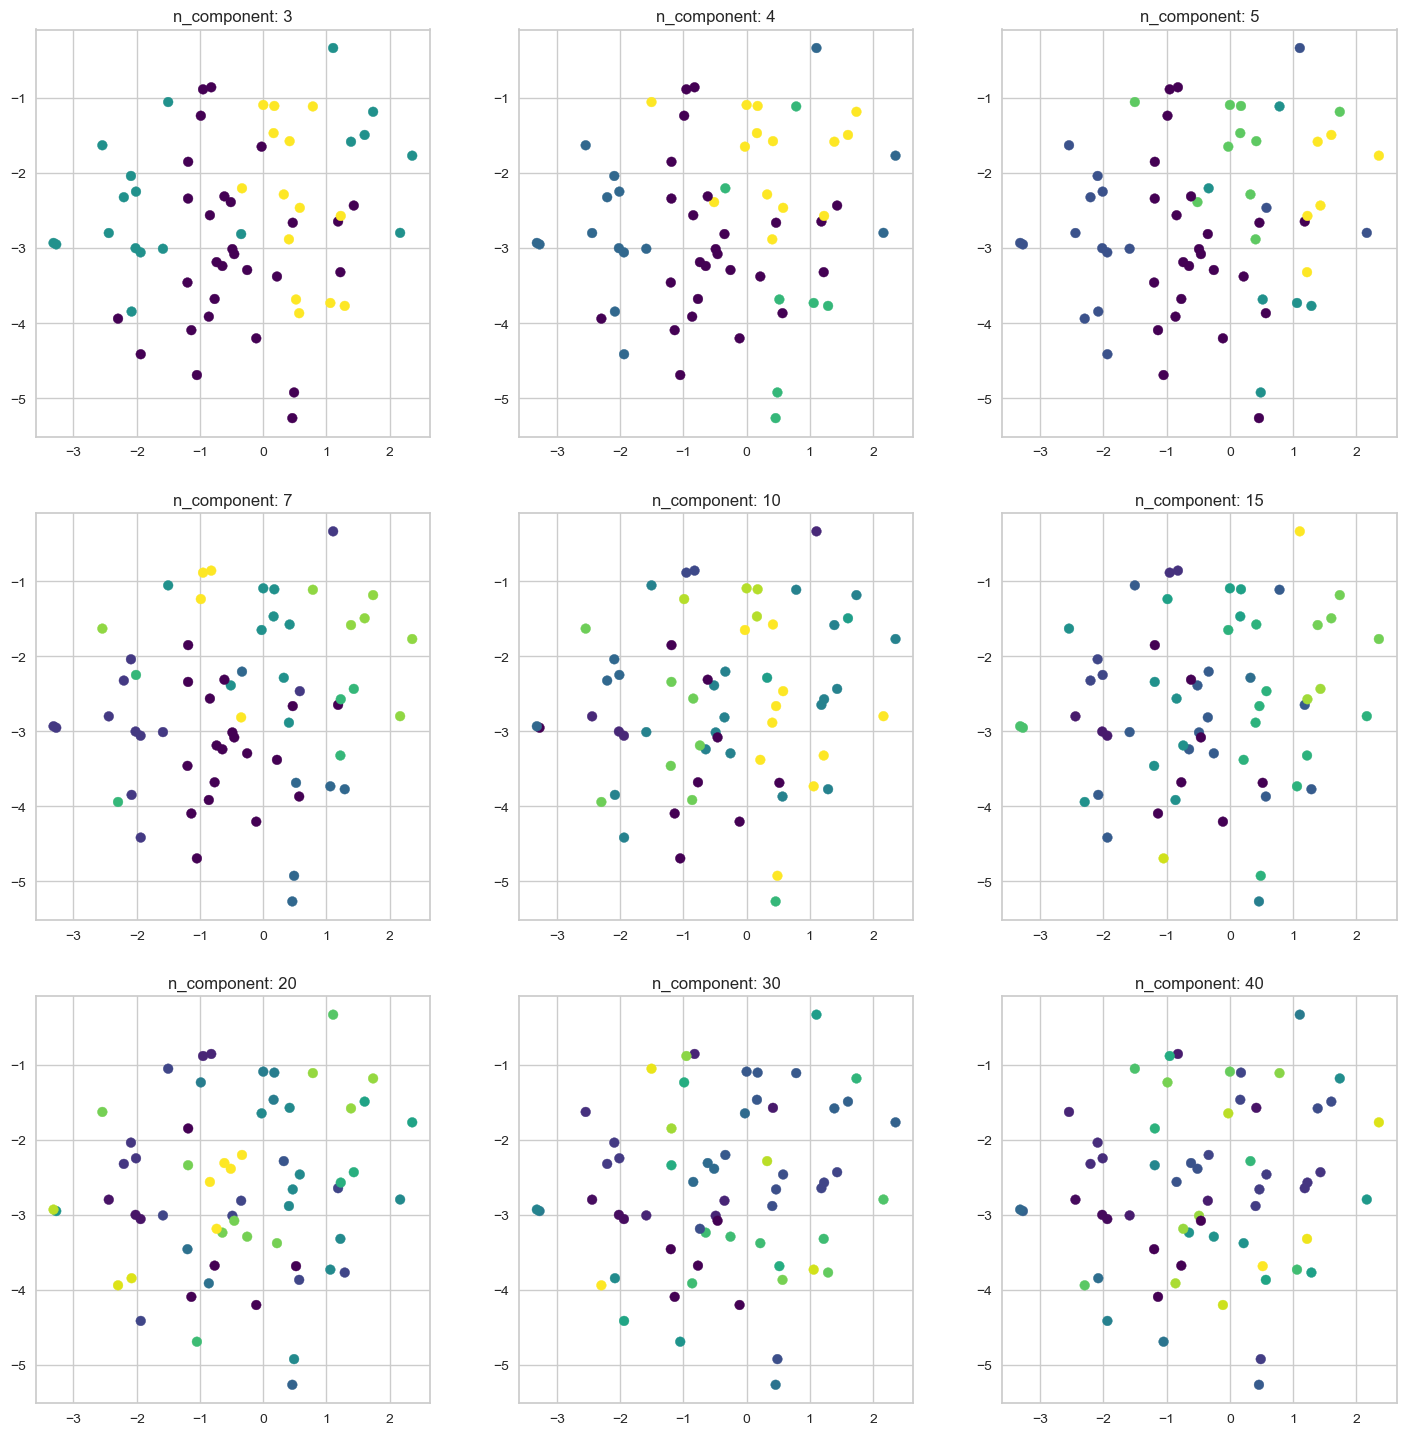

In [23]:
display_clustering(gm_iterations, 3)

In [62]:
gm = GaussianMixture(n_components=5, random_state=0).fit(data_numerical_scaled)
gm_labels = gm.predict(data_numerical_scaled)
data_numerical["Cluster"] = gm_labels

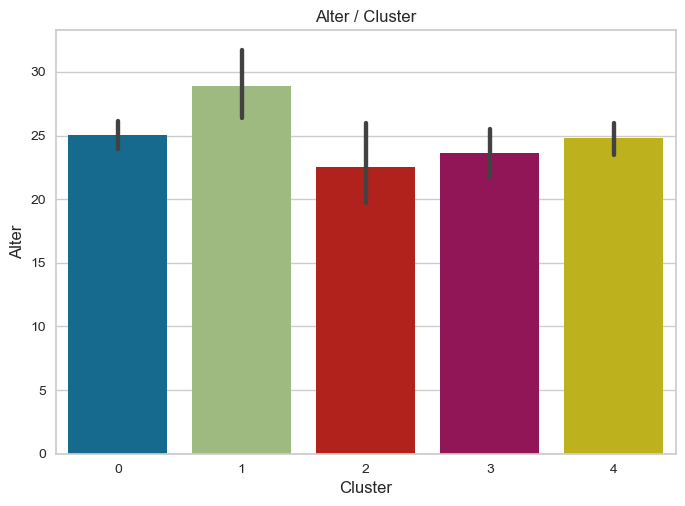

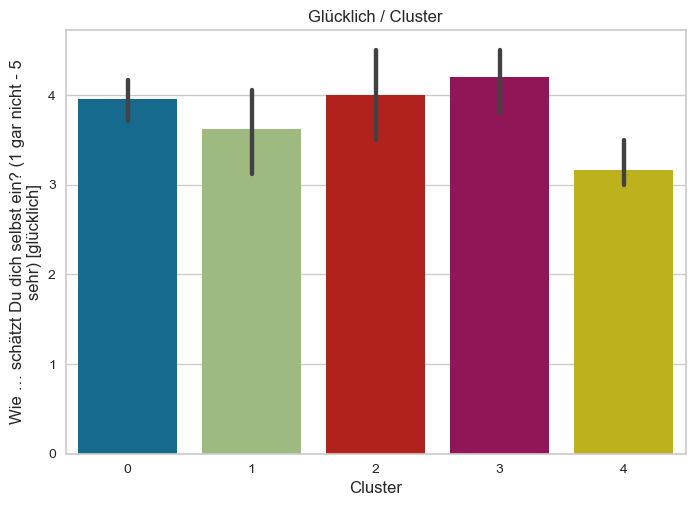

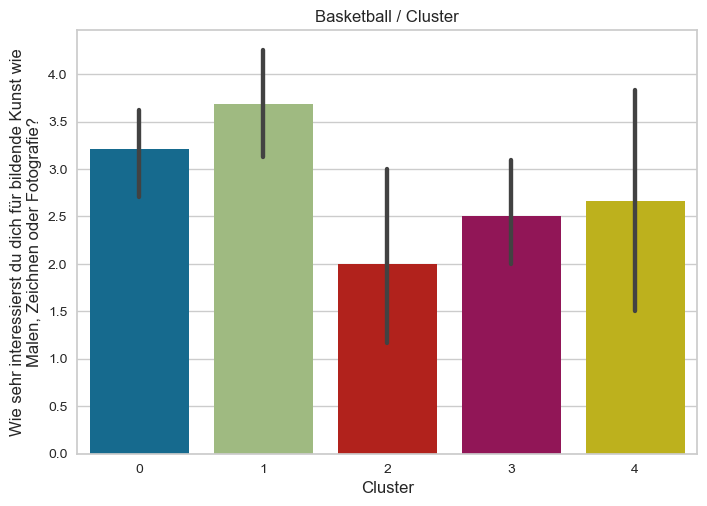

In [63]:
sb.barplot(x='Cluster', y=columns.alter, data=data_numerical)
plt.title("Alter / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.gluecklich, data=data_numerical)
plt.title("Glücklich / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.malen, data=data_numerical)
plt.title("Basketball / Cluster")
plt.show()

### Erkenntnisse / Beobachtungen
- Bei Berechnung wird k-Means in der "Initialization Method" genutzt, um Startpunkte für Clusterzentren für weitere Berechnung zu wählen
- Dies wird auch anhand der finalen Cluster deutlich, die (fast) identisch mit denen des k-Means Algorithmus sind

## 1.5 Hierarchichal Clustering

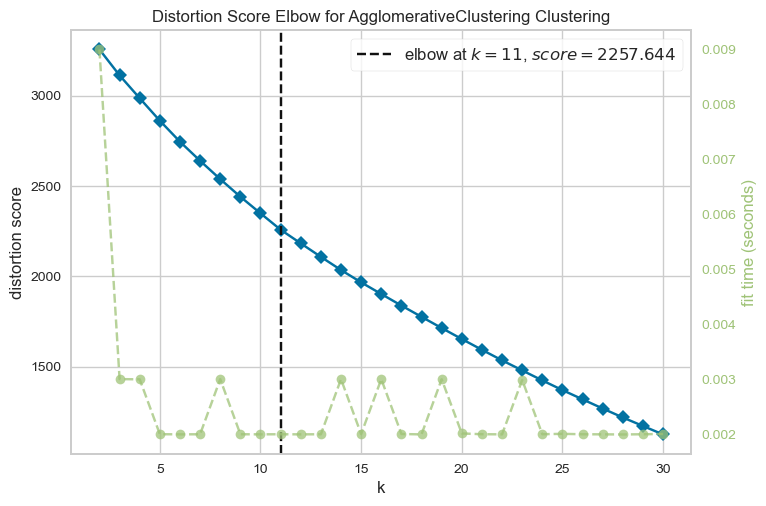

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=30)

visualizer.fit(data_numerical_scaled)
visualizer.show()

In [27]:
ward = AgglomerativeClustering(linkage="ward",
                                n_clusters=None,
                                distance_threshold=10.0)

# Variante: Cluster statt threshold angeben
# ward = AgglomerativeClustering(linkage="ward",
#	                            n_clusters=5)

ward.fit(data_numerical_scaled)

# Cluster-Zentren
ward.labels_

array([10, 21, 18,  2, 12, 17, 19, 10, 16, 13,  7,  9,  4,  9,  0,  8, 13,
       14, 24,  0, 10,  8,  7,  8,  9, 12, 10, 10, 15,  3, 23,  5, 17,  6,
       22, 14,  7, 14,  1,  0,  2,  4, 19,  3,  1, 13, 11, 20, 21,  6, 24,
       21, 23,  2, 11,  1,  5, 26,  6,  1, 23, 25], dtype=int64)

In [28]:
data_original_reduced_tsne_hc = data_original_reduced_tsne.copy()
data_original_reduced_tsne_hc["cluster"] = ward.labels_
data_original_reduced_tsne_hc

,Hyperparameter1,Hyperparameter2,cluster
0,-0.487622,-3.013880,10
1,-0.842715,-2.562919,21
2,-1.048523,-4.692399,18
3,-0.821815,-0.857486,2
4,1.184003,-2.646492,12
...,...,...,...
57,-1.936535,-4.415147,26
58,1.220311,-3.321577,6
59,-0.458000,-3.080380,1
60,-2.018291,-3.001732,23


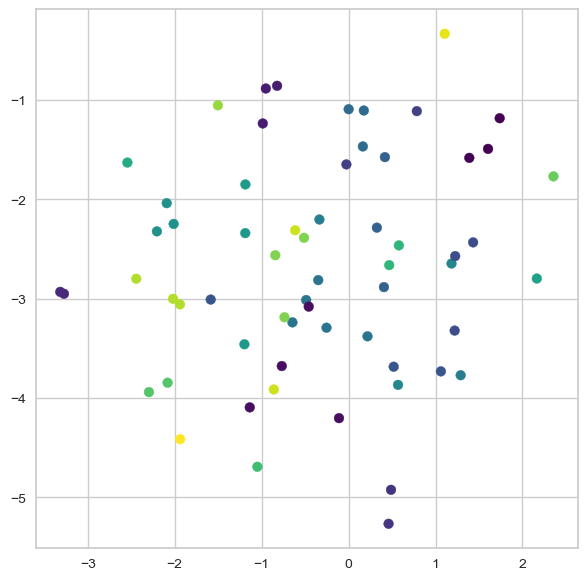

In [29]:
# Darstellung der Cluster
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data_original_reduced_tsne_hc["Hyperparameter1"], data_original_reduced_tsne_hc["Hyperparameter2"], c=data_original_reduced_tsne_hc["cluster"], cmap="viridis")

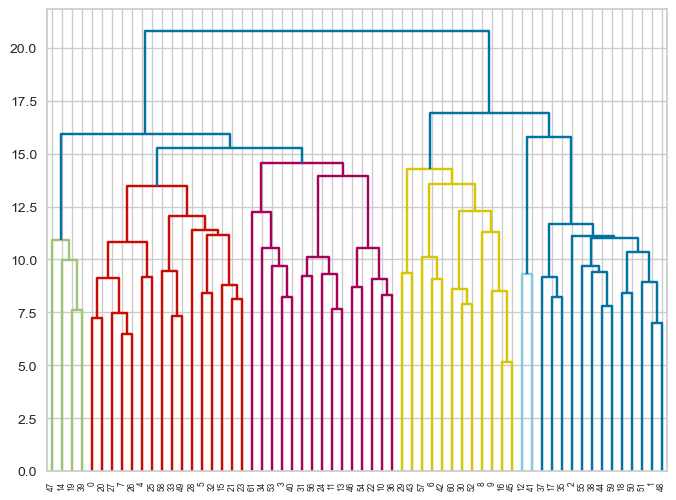

In [77]:
clusters = hierarchy.linkage(data_numerical_scaled, method="ward")
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

# Plotting a horizontal line based on the first biggest distance between clusters 
plt.axhline(150, color='red', linestyle='--'); 
# Plotting a horizontal line based on the second biggest distance between clusters 
plt.axhline(100, color='crimson'); 

# 2. Clustering nach Dimensionsreduzierung

c:\Users\Konstantin\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


<Axes: xlabel='Hyperparameter1', ylabel='Hyperparameter2'>

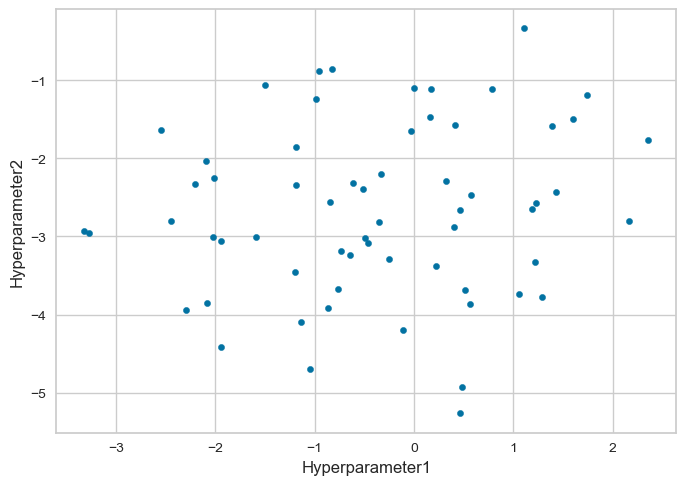

In [30]:
data_original_reduced_tsne.plot(kind="scatter", x="Hyperparameter1", y="Hyperparameter2")

## 2.1 k-Means

Wie bereits in Kapitel 1.2.1 wird mit der "Elbow"-Methode nach einer geeigneten Anzahl von Clustern gesucht...

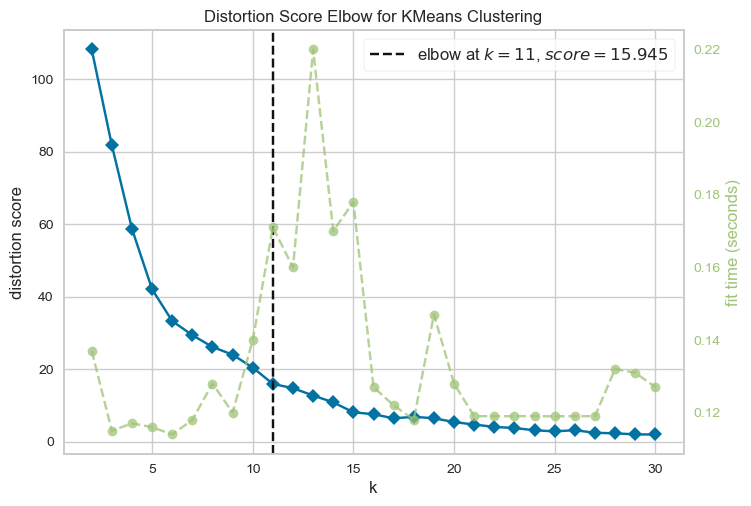

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=30)

visualizer.fit(data_original_reduced_tsne)
visualizer.show()

- Bei der Anwendung auf die reduzierten Daten ist der "Elbow" nun deutlich besser zu erkennen. Die vom Algorithmus vorgeschlagene Clustergröße von 11 kann daher als Anhaltspunkt für die weitere Untersuchung genutzt werden
- Da k-Means insb. von den zufällig gewählten Startpunkten für die Clusterzentren abhängig ist, werden zudem die umliegenden Clustergrößen wie bereits in Kapitel 1.2.2 untersucht

In [44]:
cluster_params_n_clusters = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25]
kmeans_iterations, kmeans_scores = compute_kmeans(data_original_reduced_tsne, cluster_params_n_clusters)

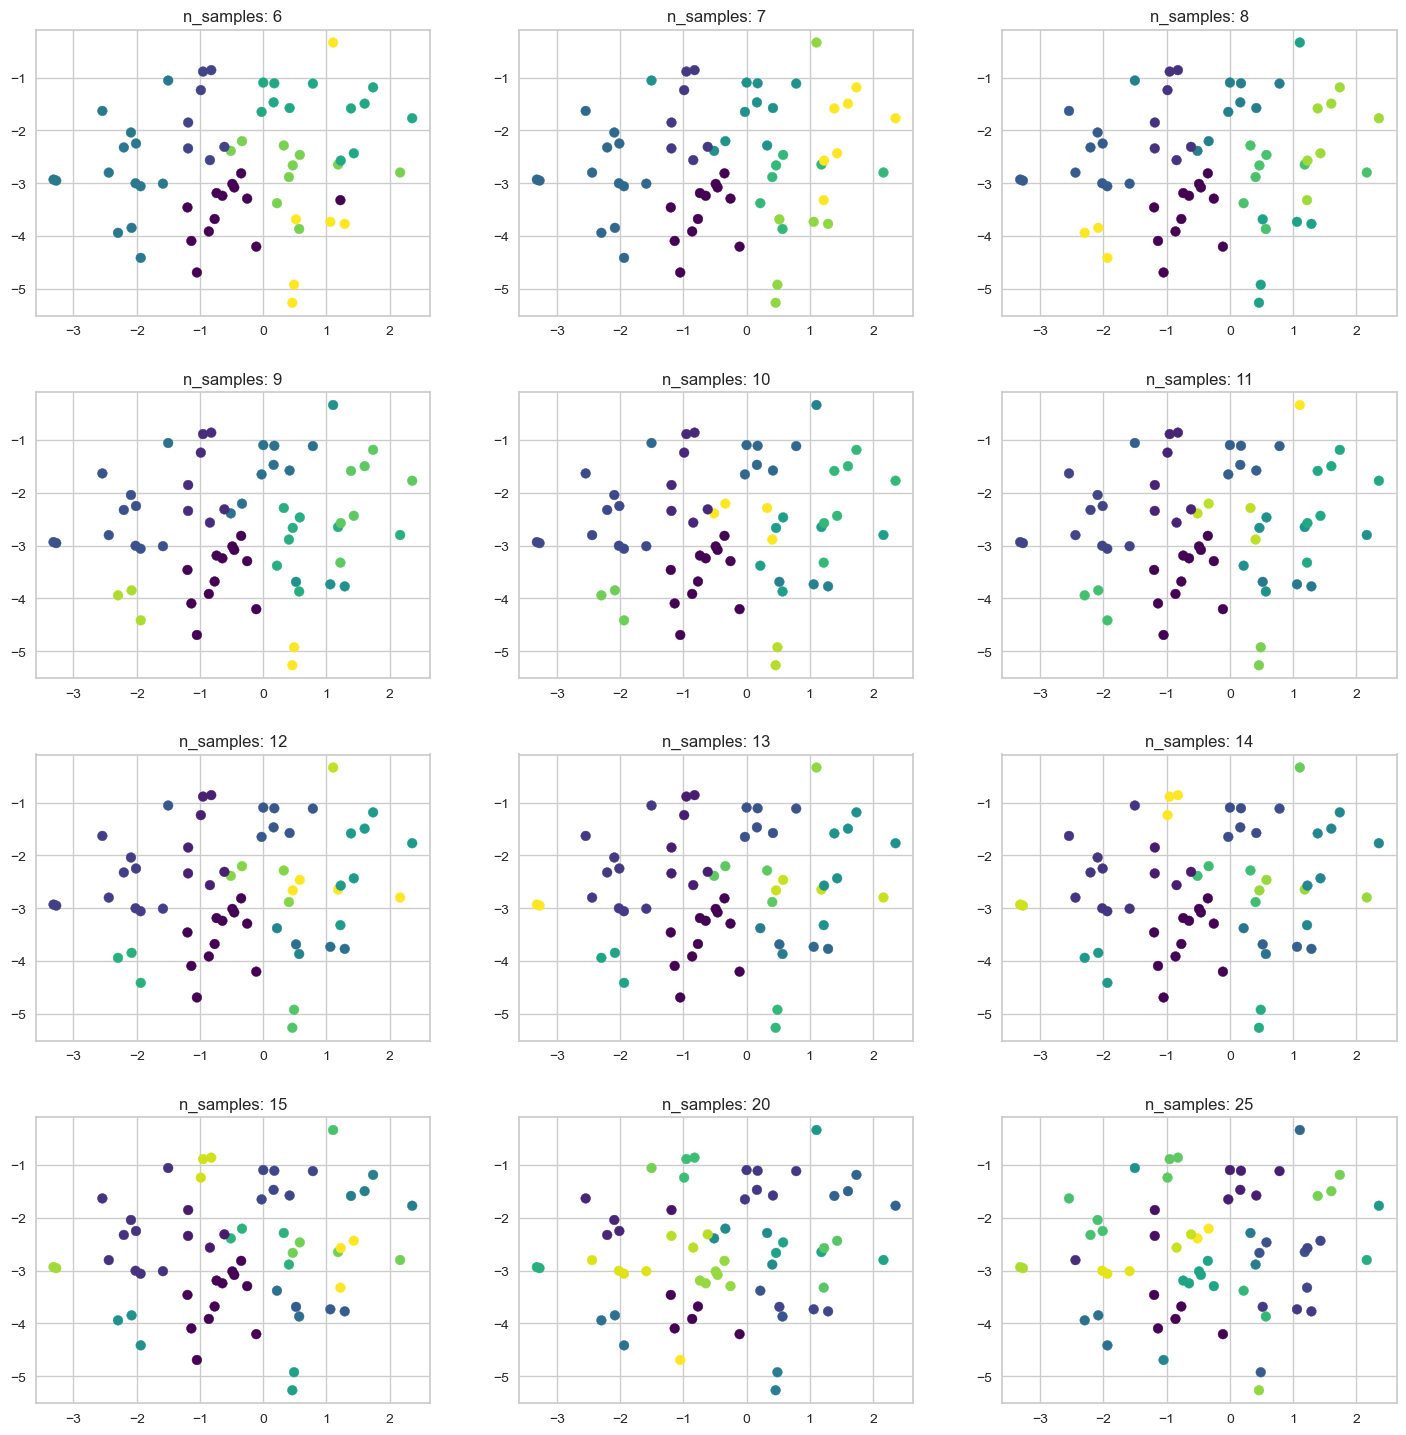

In [45]:
display_clustering(kmeans_iterations, 3, (15, 15))

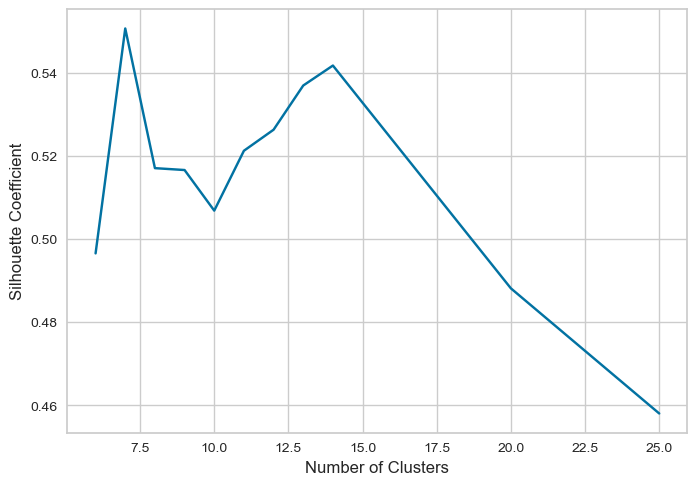

In [46]:
plt.plot(kmeans_scores.n_samples, kmeans_scores.score)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

<Axes: xlabel='Hyperparameter1', ylabel='Hyperparameter2'>

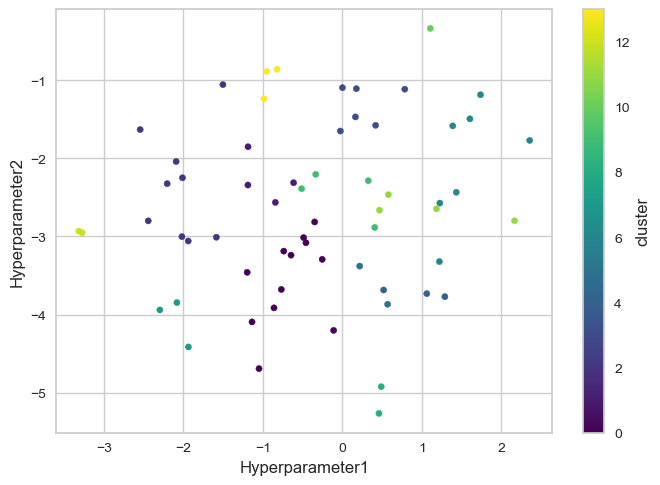

In [47]:
kmeans = KMeans(n_clusters=14, random_state=0, n_init='auto').fit(data_original_reduced_tsne)
data_original_reduced_tsne_kmeans = data_original_reduced_tsne.copy()
data_original_reduced_tsne["cluster"] = kmeans.labels_
data_original_reduced_tsne.plot(kind="scatter", x="Hyperparameter1", y="Hyperparameter2", c="cluster", cmap="viridis")

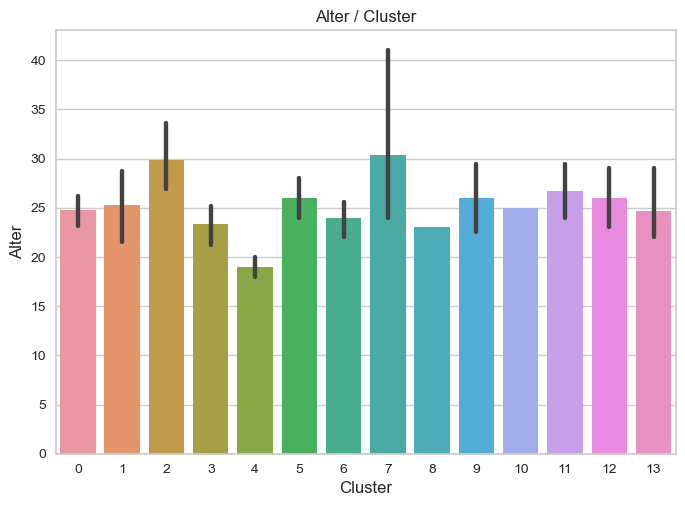

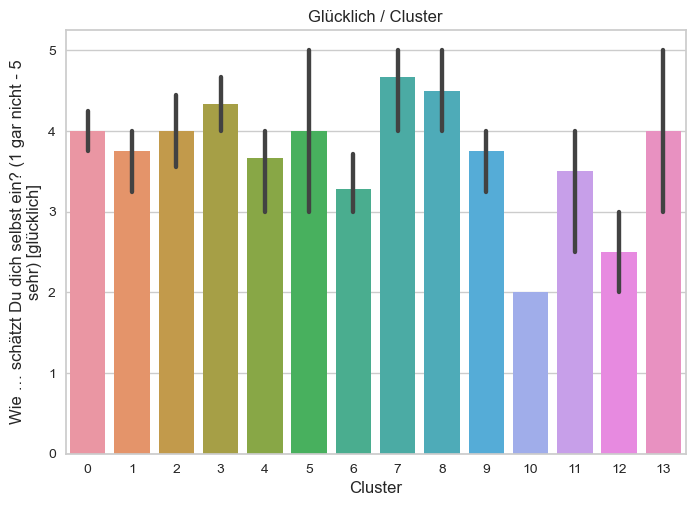

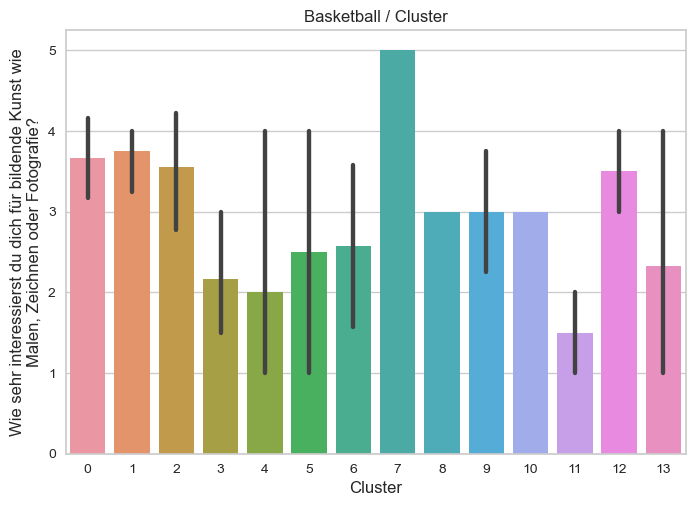

In [48]:
data_numerical["Cluster"] = kmeans.labels_

sb.barplot(x='Cluster', y=columns.alter, data=data_numerical)
plt.title("Alter / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.gluecklich, data=data_numerical)
plt.title("Glücklich / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.malen, data=data_numerical)
plt.title("Basketball / Cluster")
plt.show()

### Ergebnisse / Beobachtungen
-

## 2.2 DBSCAN

Wie bereits in Kapitel 1.3.1 wird auch hier mit der "Elbow"-Methode nach geeigneten Parametern (epsilon) gesucht...

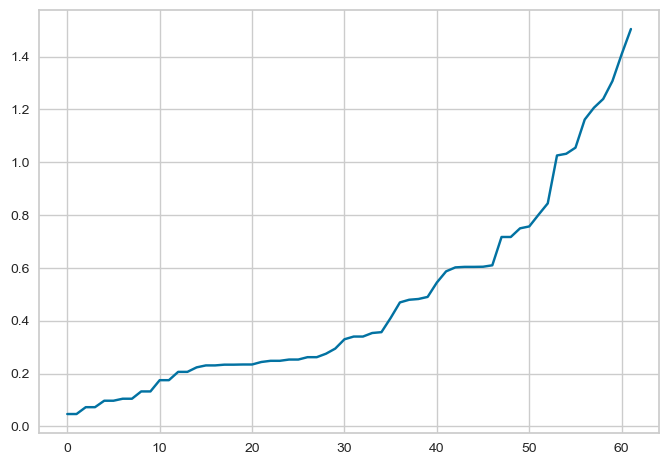

In [33]:
# based on https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data_original_reduced_tsne)
distances, indices = neighbors_fit.kneighbors(data_original_reduced_tsne)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

TODO

- Bei der Anwendung auf die reduzierten Daten ist der "Elbow" nun deutlich besser zu erkennen. Die vom Algorithmus vorgeschlagene Clustergröße von 11 kann daher als Anhaltspunkt für die weitere Untersuchung genutzt werden
- Da k-Means insb. von den zufällig gewählten Startpunkten für die Clusterzentren abhängig ist, werden zudem die umliegenden Clustergrößen wie bereits in Kapitel 1.2.2 untersucht

In [56]:
cluster_params_min_samples = [3, 4, 5, 6, 7]
cluster_params_eps = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]

dbscan_iterations = compute_dbscan(data_original_reduced_tsne, cluster_params_min_samples, cluster_params_eps)

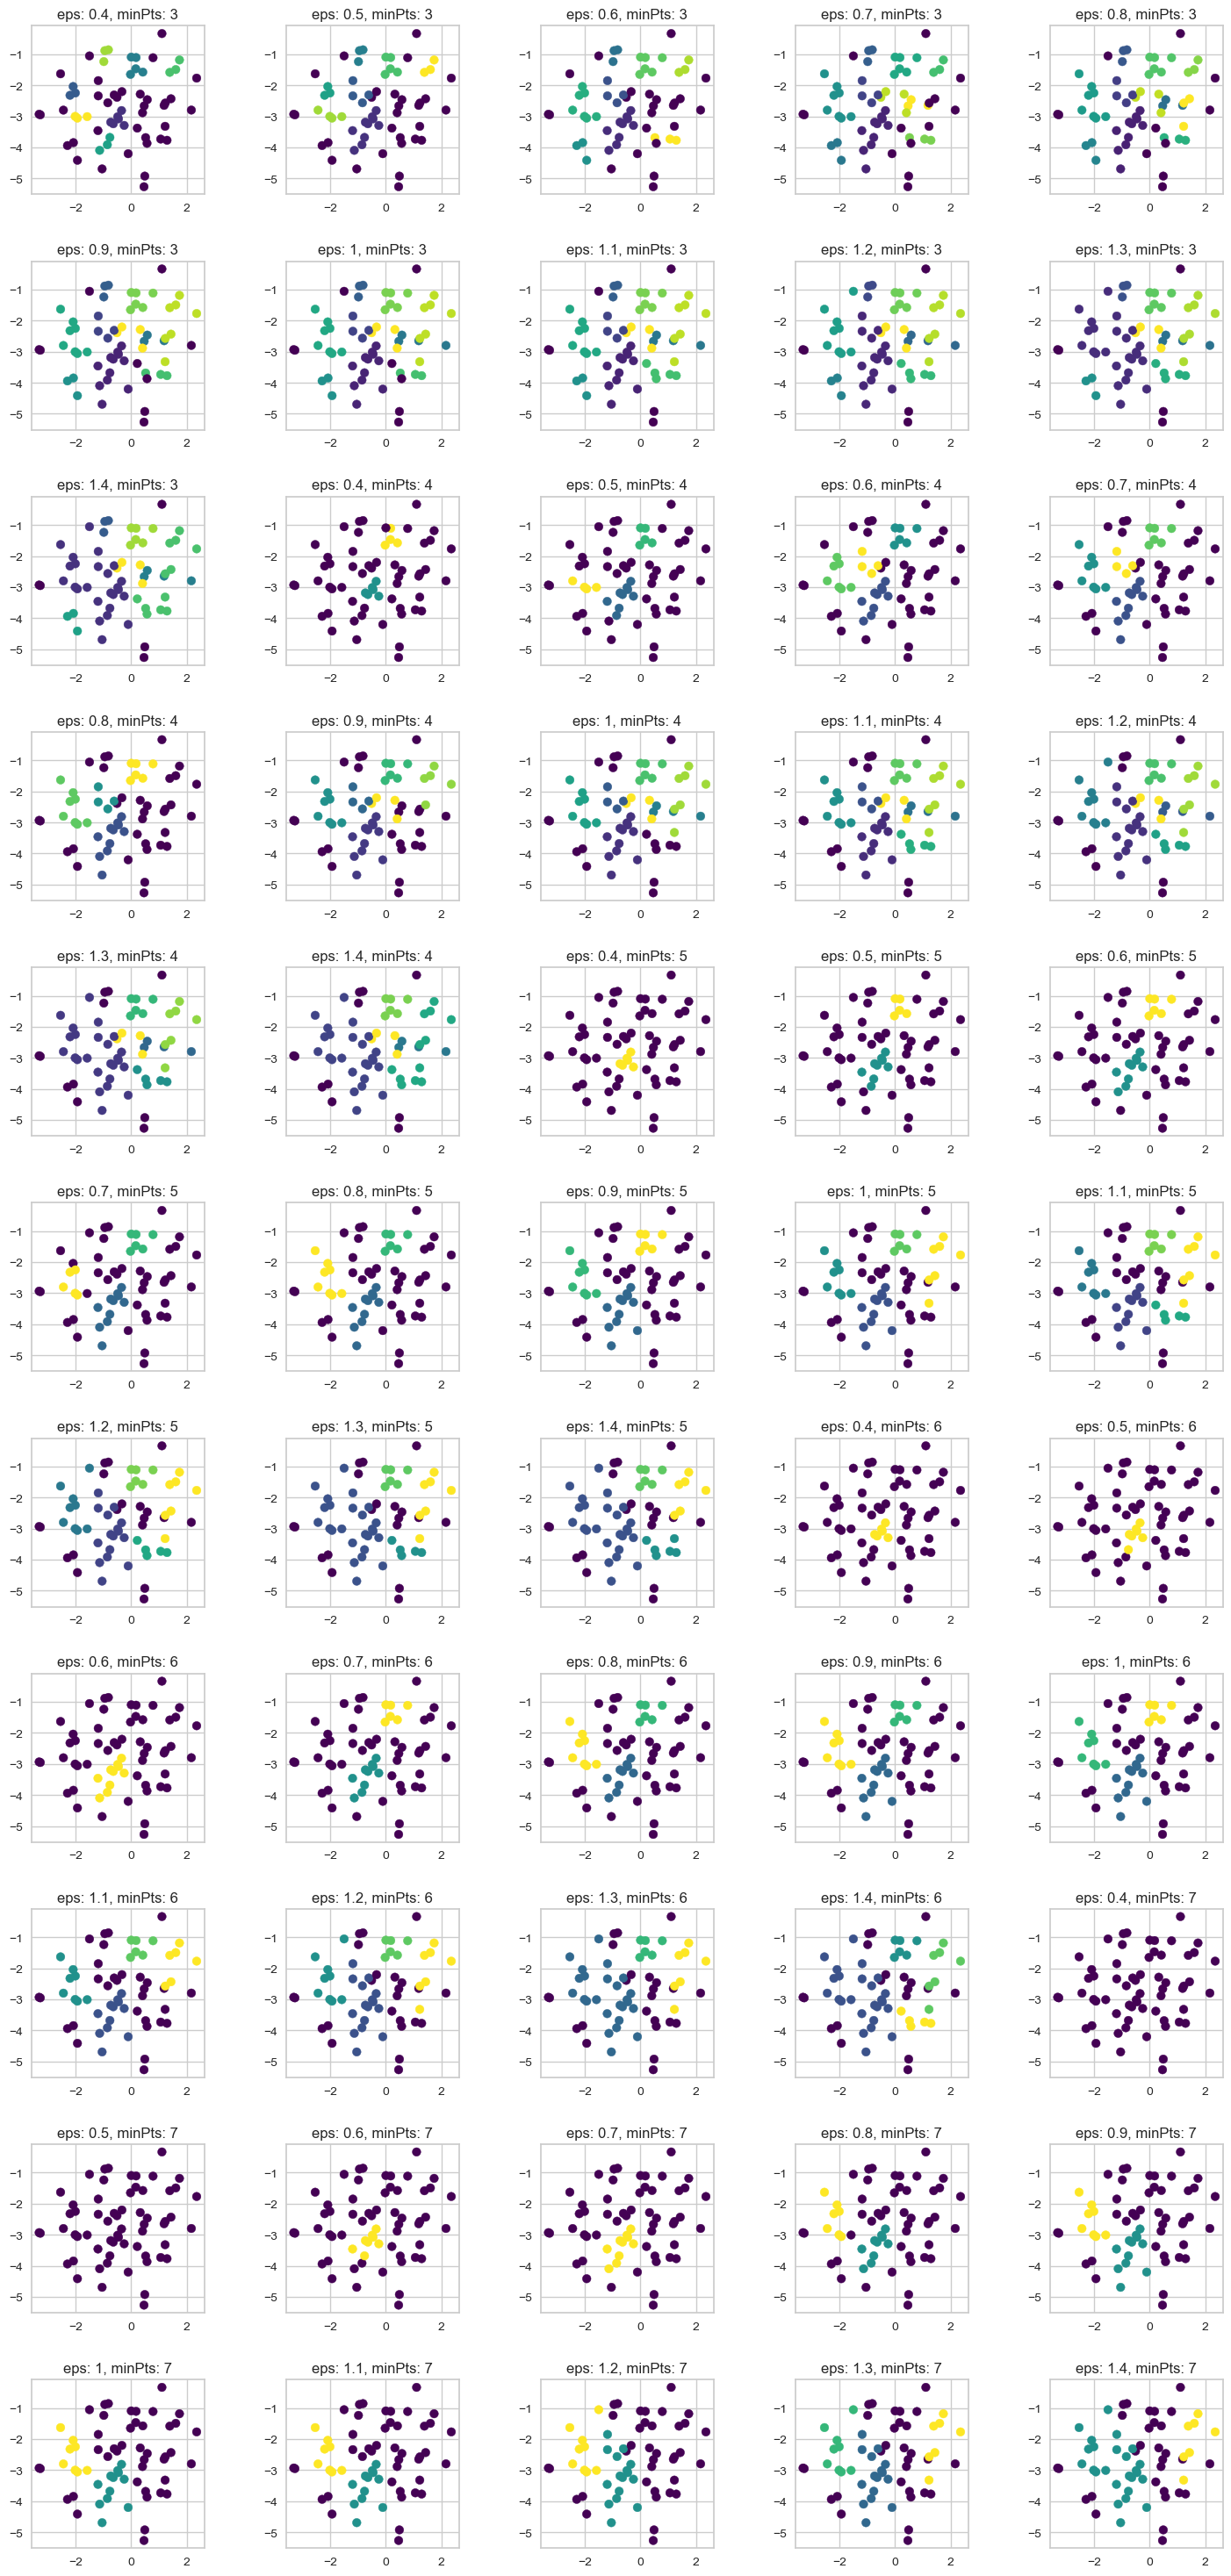

In [57]:
display_clustering(dbscan_iterations, 5, (15, 30))

## 2.4 Gaussian Mixture Model

In [59]:
cluster_params_n_components = [3, 4, 5, 7, 10, 15, 20, 30, 40]
gm_iterations = compute_gm(data_original_reduced_tsne, cluster_params_n_components)

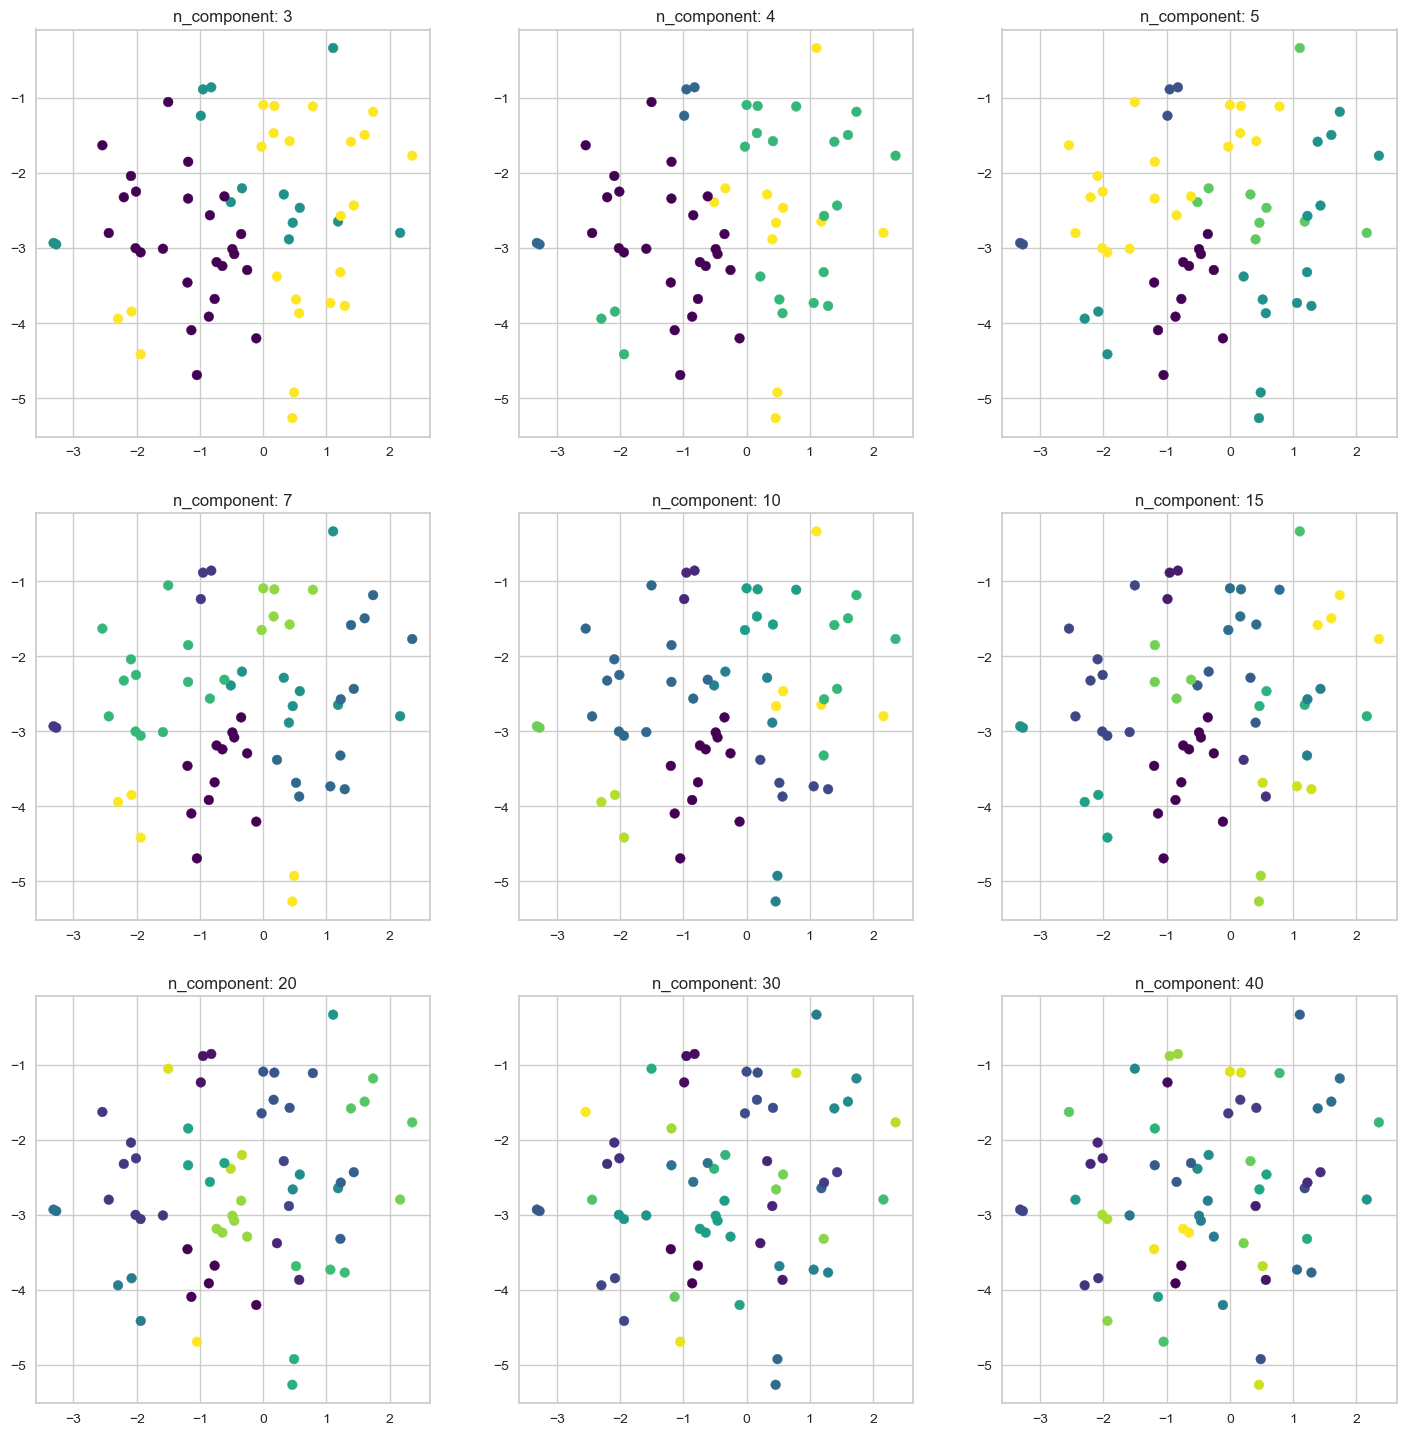

In [60]:
display_clustering(gm_iterations, 3)

In [65]:
gm = GaussianMixture(n_components=5, random_state=0).fit(data_original_reduced_tsne)
gm_labels = gm.predict(data_original_reduced_tsne)
data_numerical["Cluster"] = gm_labels

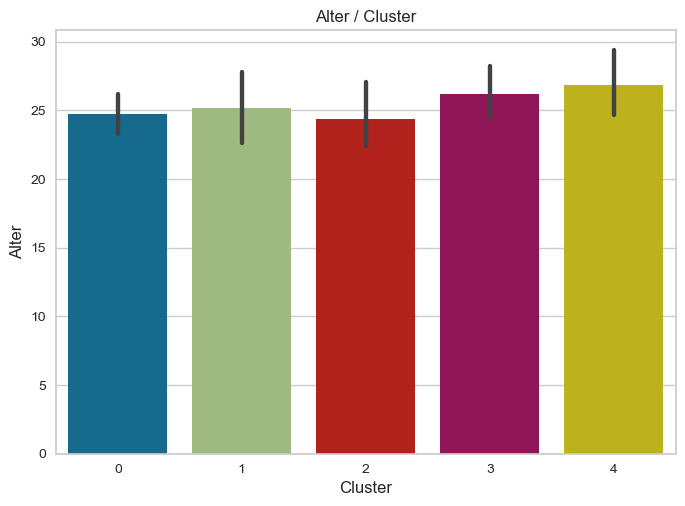

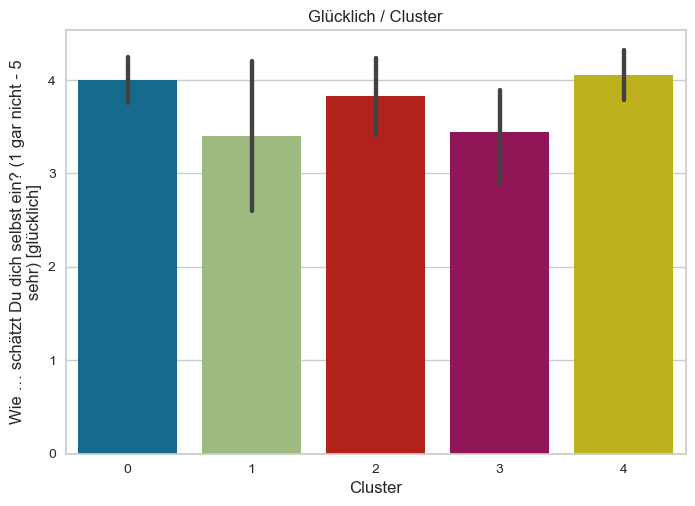

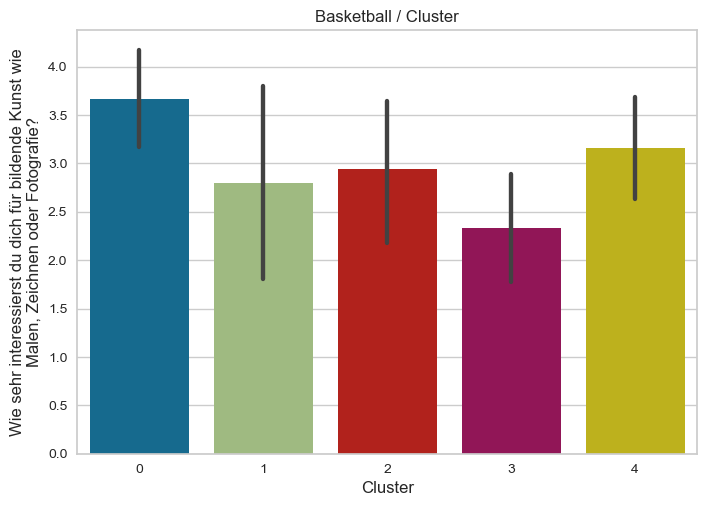

In [66]:
sb.barplot(x='Cluster', y=columns.alter, data=data_numerical)
plt.title("Alter / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.gluecklich, data=data_numerical)
plt.title("Glücklich / Cluster")
plt.show()

sb.barplot(x='Cluster', y=columns.malen, data=data_numerical)
plt.title("Basketball / Cluster")
plt.show()

### Ergebnisse / Beobachtungen
- Wie bereits in Kapitel 1.4 stimmen die berechneten Cluster (fast) vollständig mit den von k-Means berechneten Clustern überein

## 2.5 Hierarchichal Clustering

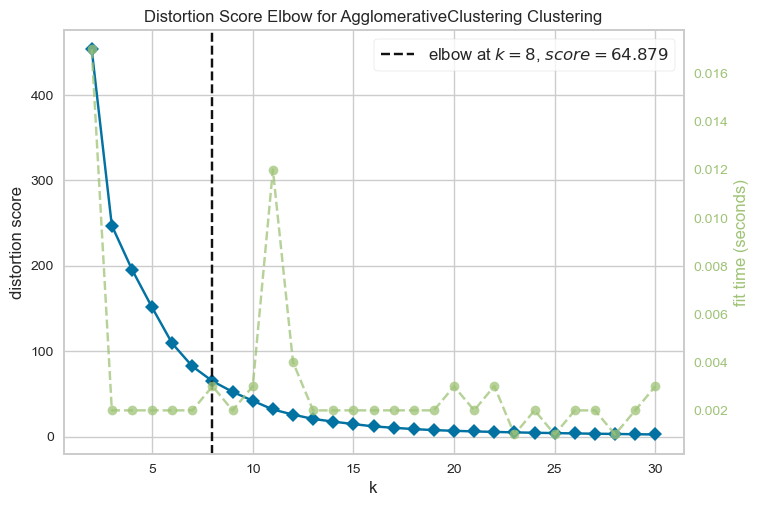

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=30)

visualizer.fit(data_original_reduced_tsne)
visualizer.show()

In [70]:
ward = AgglomerativeClustering(linkage="ward",
                                n_clusters=8)

# Variante: Cluster statt threshold angeben
# ward = AgglomerativeClustering(linkage="ward",
#	                            n_clusters=5)

ward.fit(data_numerical_scaled)

# Cluster-Zentren
ward.labels_

array([5, 1, 1, 6, 5, 5, 2, 5, 2, 2, 0, 0, 4, 0, 3, 5, 2, 1, 1, 3, 5, 5,
       0, 5, 0, 5, 5, 5, 5, 7, 2, 0, 5, 5, 6, 1, 0, 1, 1, 3, 6, 4, 2, 7,
       1, 2, 0, 3, 1, 5, 1, 1, 2, 6, 0, 1, 0, 2, 5, 1, 2, 6], dtype=int64)

In [71]:
data_original_reduced_tsne_hc = data_original_reduced_tsne.copy()
data_original_reduced_tsne_hc["cluster"] = ward.labels_
data_original_reduced_tsne_hc

,Hyperparameter1,Hyperparameter2,cluster
0,-0.487622,-3.013880,5
1,-0.842715,-2.562919,1
2,-1.048523,-4.692399,1
3,-0.821815,-0.857486,6
4,1.184003,-2.646492,5
...,...,...,...
57,-1.936535,-4.415147,2
58,1.220311,-3.321577,5
59,-0.458000,-3.080380,1
60,-2.018291,-3.001732,2


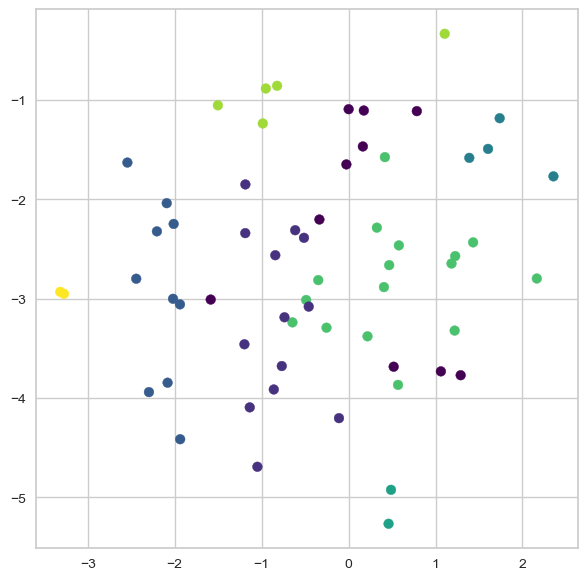

In [72]:
# Darstellung der Cluster
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data_original_reduced_tsne_hc["Hyperparameter1"], data_original_reduced_tsne_hc["Hyperparameter2"], c=data_original_reduced_tsne_hc["cluster"], cmap="viridis")

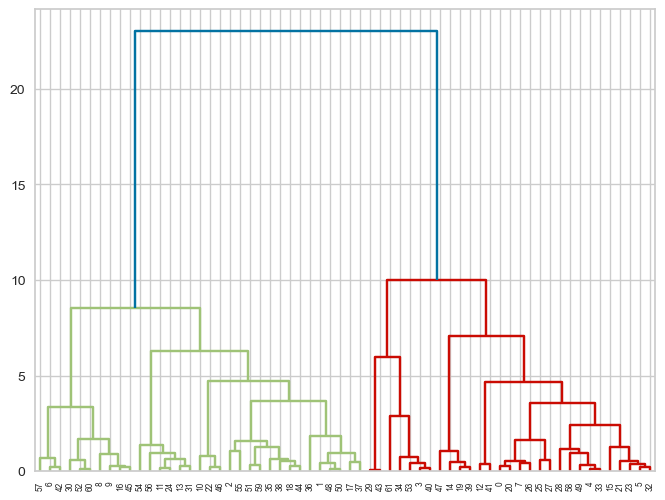

In [74]:
clusters = hierarchy.linkage(data_original_reduced_tsne_hc, method="ward")
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

# Plotting a horizontal line based on the first biggest distance between clusters 
plt.axhline(150, color='red', linestyle='--'); 
# Plotting a horizontal line based on the second biggest distance between clusters 
plt.axhline(100, color='crimson'); 